In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
img_patch = [[43,46,97,170,192],[42,47,99,171,192],[43,46,100,172,190],[43,45,100,175,192],[43,46,101,176,192]]

In [3]:
img_patch = np.array(img_patch)

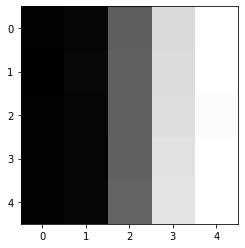

In [4]:
plt.imshow(img_patch, cmap='gray')

In [5]:
# Function to perform convolution of the input image with the kernel
def convolution(img, kernel, average=False, verbose=False):
    if len(img.shape) == 3:
        print("Found 3 Channels : {}".format(img.shape))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        print("Converted to Gray Channel. Size : {}".format(img.shape))
    else:
        print("img Shape : {}".format(img.shape))
 
    print("Kernel Shape : {}".format(kernel.shape))
 
    if verbose:
        plt.imshow(img, cmap='gray')
        plt.title("img")
        plt.show()
 
    img_row, img_col = img.shape
    kernel_row, kernel_col = kernel.shape
 
    output = np.zeros(img.shape)
 
    height = int((kernel_row - 1) / 2)
    width = int((kernel_col - 1) / 2)
 
    img_p = np.zeros((img_row + (2 * height), img_col + (2 * width)))
 
    img_p[height:img_p.shape[0] - height, width:img_p.shape[1] - width] = img
 
    if verbose:
        plt.imshow(img_p, cmap='gray')
        plt.title("Padded img")
        plt.show()
 
    for row in range(img_row):
        for col in range(img_col):
            output[row, col] = np.sum(kernel * img_p[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]
 
    print("Output img size : {}".format(output.shape))
 
    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Output img using {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()
 
    return output

In [6]:
#Functions to generate a Gaussian kernel and blur a given image by performing convolution with the image and the generated kernel. 
# This will produce an average (blurring) effect.

def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)
 
def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
 
    kernel_2D *= 1.0 / kernel_2D.max()
 
    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel ( {}X{} )".format(size, size))
        plt.show()
 
    return kernel_2D
 
def gaussian_blur(img, kernel_size, verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma=1, verbose=verbose)
    return convolution(img, kernel, average=True, verbose=verbose)

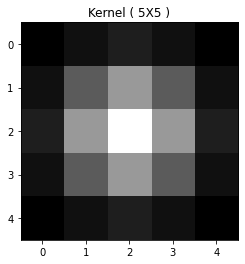

img Shape : (5, 5)
Kernel Shape : (5, 5)


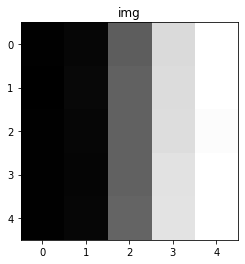

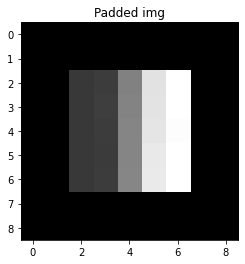

Output img size : (5, 5)


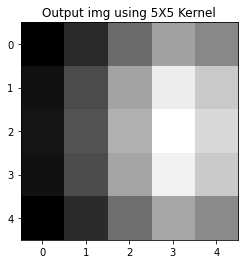

In [7]:
blurred_patch = gaussian_blur(img_patch, 5, True)

In [8]:
kernel = gaussian_kernel(5, sigma=1)

In [9]:
kernel

array([[0.01831564, 0.082085  , 0.13533528, 0.082085  , 0.01831564],
       [0.082085  , 0.36787944, 0.60653066, 0.36787944, 0.082085  ],
       [0.13533528, 0.60653066, 1.        , 0.60653066, 0.13533528],
       [0.082085  , 0.36787944, 0.60653066, 0.36787944, 0.082085  ],
       [0.01831564, 0.082085  , 0.13533528, 0.082085  , 0.01831564]])

In [10]:
sobel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
sobel_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

In [11]:
# Defining Sobel operator for edge detection in the X and Y axes
def sobel_edge_detection(img, filter_x, filter_y, convert_to_degree=False, verbose=False):
    new_img_x = convolution(img, filter_x, verbose)

    if verbose:
        plt.imshow(new_img_x, cmap='gray')
        plt.title("Horizontal Edge")
        plt.show()

    new_img_y = convolution(img, filter_y, verbose)

    if verbose:
        plt.imshow(new_img_y, cmap='gray')
        plt.title("Vertical Edge")
        plt.show()

    gradient_magnitude = np.sqrt(np.square(new_img_x) + np.square(new_img_y))

    gradient_magnitude *= 255.0 / gradient_magnitude.max()

    if verbose:
        plt.imshow(gradient_magnitude, cmap='gray')
        plt.title("Gradient Magnitude")
        plt.show()

    gradient_direction = np.arctan2(new_img_y, new_img_x)

    if convert_to_degree:
        gradient_direction = np.rad2deg(gradient_direction)
        gradient_direction += 180

    return gradient_magnitude, gradient_direction

img Shape : (5, 5)
Kernel Shape : (3, 3)
Output img size : (5, 5)


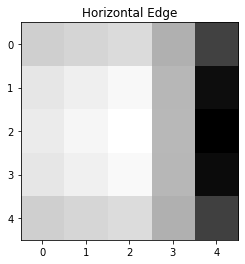

img Shape : (5, 5)
Kernel Shape : (3, 3)
Output img size : (5, 5)


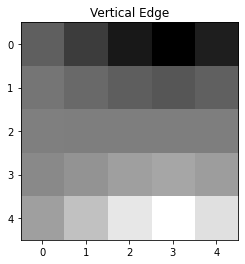

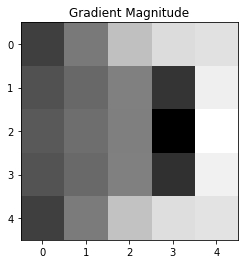

In [12]:
gradient_magnitude, gradient_direction = sobel_edge_detection(blurred_patch, sobel_x,sobel_y, verbose=True)

In [13]:
def non_max_suppression(gradient_magnitude, gradient_direction, verbose):
    img_row, img_col = gradient_magnitude.shape
 
    output = np.zeros(gradient_magnitude.shape)
 
    PI = 180
 
    for row in range(1, img_row - 1):
        for col in range(1, img_col - 1):
            direction = gradient_direction[row, col]
 
            if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
                before_pixel = gradient_magnitude[row, col - 1]
                after_pixel = gradient_magnitude[row, col + 1]
 
            elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
                before_pixel = gradient_magnitude[row + 1, col - 1]
                after_pixel = gradient_magnitude[row - 1, col + 1]
 
            elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
                before_pixel = gradient_magnitude[row - 1, col]
                after_pixel = gradient_magnitude[row + 1, col]
 
            else:
                before_pixel = gradient_magnitude[row - 1, col - 1]
                after_pixel = gradient_magnitude[row + 1, col + 1]
 
            if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
                output[row, col] = gradient_magnitude[row, col]
 
    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Non Max Suppression")
        plt.show()
 
    return output

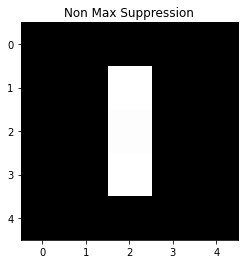

In [14]:
final_img = non_max_suppression(gradient_magnitude, gradient_direction, verbose=True)